# ⛱️  EDA Multimodal Signal Processing (MSP)
### UTEC - Continuous Emotion Inference & Analytics @ MSP-Conversation corpus
#### Paulo - Emmanuel - Wilton

In [3]:
import os
import sys
sys.path.append("../")
from pathlib import Path
import base64
import math
import pickle
from operator import itemgetter 
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
import scipy.signal as signal
from scipy.io import wavfile
import IPython
from IPython.display import HTML, display, display_html
from src.futil import stereo_to_mono, resample, table_with_sound

# Path a el dataset, se tiene que cambiar para cada usuario
root_path = "C:/Users/Emanuel/Documents/Github/MSP corpus"

# Abro archivo con audio, path y duración
with open("../data/audiolist.pkl", "rb") as pkl:
    audios = pickle.load(pkl)

In [7]:
# Cargar audiolist a un dataframe "df" 
columns = ['Audio_Name', 'Audio_Path', 'Duration']
df = pd.DataFrame(data=audios, columns=columns)
print(f"MSP full conversations {len(df)} \n")

# Muestro audios para ver, sample debe ser >= 2
# table_with_sound(df.sample(2), audio_column='Audio_Path', columns=columns)

MSP full conversations 244 



Text(0.5, 0, 'Duration in seconds')

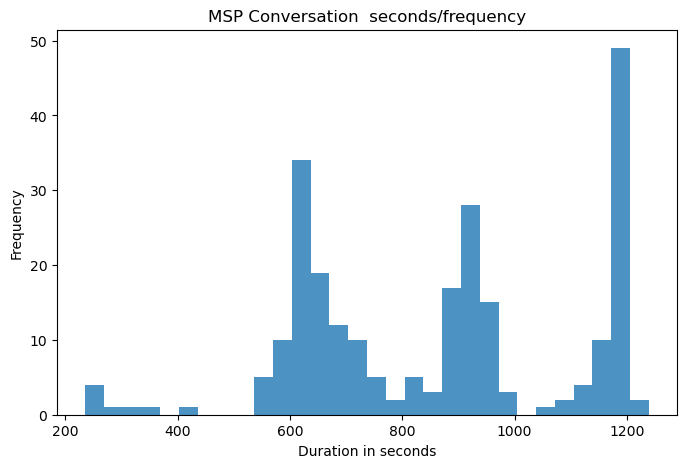

In [8]:
# Histograma de la duración de los audios
ax = df['Duration'].plot.hist(bins=30, alpha=0.8, figsize=(8, 5))
ax.set_title(f"MSP Conversation  seconds/frequency")
ax.set_xlabel("Duration in seconds")

In [9]:
# Lee el archivo que identifica como los audios estan divididos
dfconv = pd.read_csv(f"{root_path}/Time_Labels/conversation_parts.txt", delimiter=";", header=None, names=['Conversation_Part', 'start_time', 'end_time'])

# Creamos dos columnas con el podcast number y la parte de ese podcast
dfconv['PC_Num'] = dfconv['Conversation_Part'].apply(lambda x: x[17:21]).astype(int)
dfconv['Part_Num'] = dfconv['Conversation_Part'].apply(lambda x: x[22:23]).astype(int)

mem = {}

def add_sync_time_columns(row):
    if row.Part_Num == 1:
        st = 0
        mem[row.PC_Num] = row.start_time
    else:
        st = row.start_time - mem[row.PC_Num]
        
    row['m_start_time'] = st
    row['m_end_time'] = row.end_time - mem[row.PC_Num]
    
    return row

# Una fila con los audios en formato inicio: 0 y final: final - inicio
dfconv = dfconv.apply(lambda row: add_sync_time_columns(row), axis=1)
dfconv = dfconv[['Conversation_Part', 'm_start_time', 'm_end_time', 'PC_Num', 'Part_Num']]
print(f"MSP Conversation parts: {len(dfconv)}\n")
dfconv.head(10)


MSP Conversation parts: 695



,Conversation_Part,m_start_time,m_end_time,PC_Num,Part_Num
0,MSP-Conversation_0021_1,0.0000,306.0304,21,1
1,MSP-Conversation_0021_2,306.0304,602.2578,21,2
2,MSP-Conversation_0021_3,602.2578,905.2362,21,3
3,MSP-Conversation_0021_4,905.2362,1138.0000,21,4
4,MSP-Conversation_0023_1,0.0000,343.9248,23,1
5,MSP-Conversation_0023_2,343.9248,606.3344,23,2
6,MSP-Conversation_0035_1,0.0000,266.7543,35,1
7,MSP-Conversation_0035_2,266.7543,677.0000,35,2
8,MSP-Conversation_0047_1,0.0000,332.8091,47,1
9,MSP-Conversation_0047_2,332.8091,617.1787,47,2


Text(0.5, 0, 'Duration in seconds')

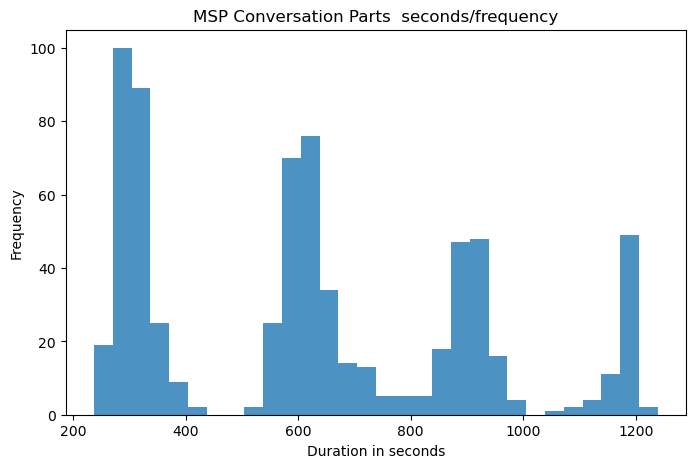

In [10]:
# Histograma de duración de cada conversación
ax = dfconv['m_end_time'].plot.hist(bins=30, alpha=0.8, figsize=(8, 5))
ax.set_title(f"MSP Conversation Parts  seconds/frequency")
ax.set_xlabel("Duration in seconds")

<Axes: >

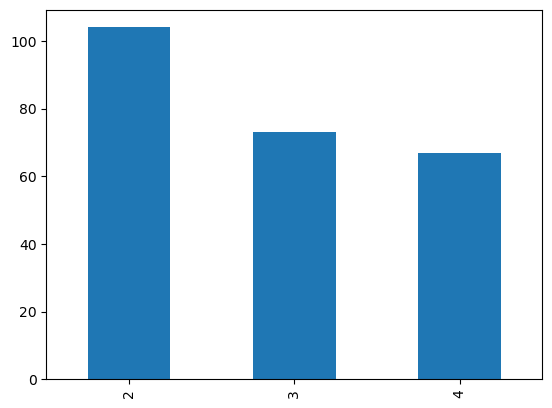

In [11]:
dfconv.groupby(by='PC_Num').Part_Num.count().value_counts().plot(kind='bar')

In [12]:
dfconv[dfconv['PC_Num'] == 475].groupby('PC_Num').max()

,Conversation_Part,m_start_time,m_end_time,Part_Num
PC_Num,,,,
475,MSP-Conversation_0475_2,319.6092,635.3668,2


In [13]:
EMO_Valence = 'Valence'
EMO_Arousal = 'Arousal'
EMO_Dominance = 'Dominance'

def get_dfannot_by_dim(emot: str):
    """Get df of MSP-Conversation files part"""
    ANNOTATIONS_PATH = Path(f'{root_path}/Annotations/{emot}')
    
    anns = []
    # Itero por todos los csv de la carpeta emot
    for ann in ANNOTATIONS_PATH.rglob("*.csv"):
        # Se abre cada archivo csv
        with open(ann.__str__(), 'rbU') as af:
            # Se define la variable linea como la cantidad de lineas del archivo exceptuando las 9 iniciales que son cabeceras
            lines = sum(1 for _ in af) - 9
        anns.append([ann.name[17:21], ann.name[22:23], ann.name[24:27], ann.name, lines])
    
    dfannotation = pd.DataFrame(data=anns, columns=['PC_Num', 'Part_Num', 'Annotator', 'Name', 'Lines'])
    dfannotation[['PC_Num', 'Part_Num', 'Lines']] =  dfannotation[['PC_Num', 'Part_Num', 'Lines']].astype(int)
    dfannotation = dfannotation.sort_values(by=['PC_Num', 'Part_Num'])
    dfannotation = dfannotation.reset_index(drop=True)
    
    return dfannotation

# Obtengo dataframe con los datos de cada conversación y la cantidad de lineas para esa conversación
dfannotation_vale = get_dfannot_by_dim(EMO_Valence)
dfannotation_arou = get_dfannot_by_dim(EMO_Arousal)
dfannotation_domi = get_dfannot_by_dim(EMO_Dominance)

In [12]:
dfannotation_arou

,PC_Num,Part_Num,Annotator,Name,Lines
0,2,1,007,MSP-Conversation_0002_1_007.csv,12814
1,2,1,009,MSP-Conversation_0002_1_009.csv,4368
2,2,1,010,MSP-Conversation_0002_1_010.csv,1707
3,2,1,013,MSP-Conversation_0002_1_013.csv,16711
4,2,1,015,MSP-Conversation_0002_1_015.csv,3892
...,...,...,...,...,...
4221,2281,4,013,MSP-Conversation_2281_4_013.csv,16433
4222,2281,4,015,MSP-Conversation_2281_4_015.csv,3881
4223,2281,4,017,MSP-Conversation_2281_4_017.csv,16436
4224,2281,4,018,MSP-Conversation_2281_4_018.csv,1082


In [13]:
# hard hard processing.

def filter_dfannotation(emot: str, dfannotation:  pd.DataFrame, pc_num: int, part_num: int) -> list:
    """ Filter by lookup a pc_num (podcast number) with par_num (each piece of file) """
    all_annot = [] 
    # Leo cada audio, para cada anotador para le emoción especificada
    for name, annotator, lines in zip(dfannotation['Name'], dfannotation['Annotator'], dfannotation['Lines']):
        temp_df = pd.read_csv(f"{root_path}/Annotations/{emot}/{name}", skiprows=9, header=None, names=['Time', 'Annotation'])
        temp_df['Annotator'] = f"{annotator}:{lines}" # len(oneanns[i]) is the same.
        all_annot.append(temp_df)

    #TODO: all_annot is a important and computational heavy dataframe, so, used this in the near future.
    
    df_filtered = dfannotation[(dfannotation.PC_Num == pc_num) & (dfannotation.Part_Num == part_num)]
    idxs = df_filtered.index.to_list()
    return itemgetter(*idxs)(all_annot), df_filtered
    

In [11]:
PC_Num, Part_Num = 401, 2
# hard hard processing.
dfannotation_vale_filtered, df_vale_filtered = filter_dfannotation(EMO_Valence, dfannotation_vale, PC_Num, Part_Num)
dfannotation_arou_filtered, df_arou_filtered = filter_dfannotation(EMO_Arousal, dfannotation_arou, PC_Num, Part_Num)
dfannotation_domi_filtered, df_domi_filtered = filter_dfannotation(EMO_Dominance, dfannotation_domi, PC_Num, Part_Num)

df_vale_filtered

,PC_Num,Part_Num,Annotator,Name,Lines
1096,401,2,009,MSP-Conversation_0401_2_009.csv,3619
1097,401,2,019,MSP-Conversation_0401_2_019.csv,15487
1098,401,2,017,MSP-Conversation_0401_2_017.csv,15771
1099,401,2,010,MSP-Conversation_0401_2_010.csv,1580
1100,401,2,007,MSP-Conversation_0401_2_007.csv,11452
1101,401,2,013,MSP-Conversation_0401_2_013.csv,15768


In [12]:
dfannotation_vale_filtered[3] # index by each annotator.

,Time,Annotation,Annotator
0,0.04000,-0.01,010:1580
1,0.08844,-0.01,010:1580
2,0.24773,-0.01,010:1580
3,0.30100,-0.01,010:1580
4,0.55100,-0.01,010:1580
...,...,...,...
1575,267.43500,13.39,010:1580
1576,267.60020,13.39,010:1580
1577,267.73600,13.39,010:1580
1578,267.92160,9.45,010:1580


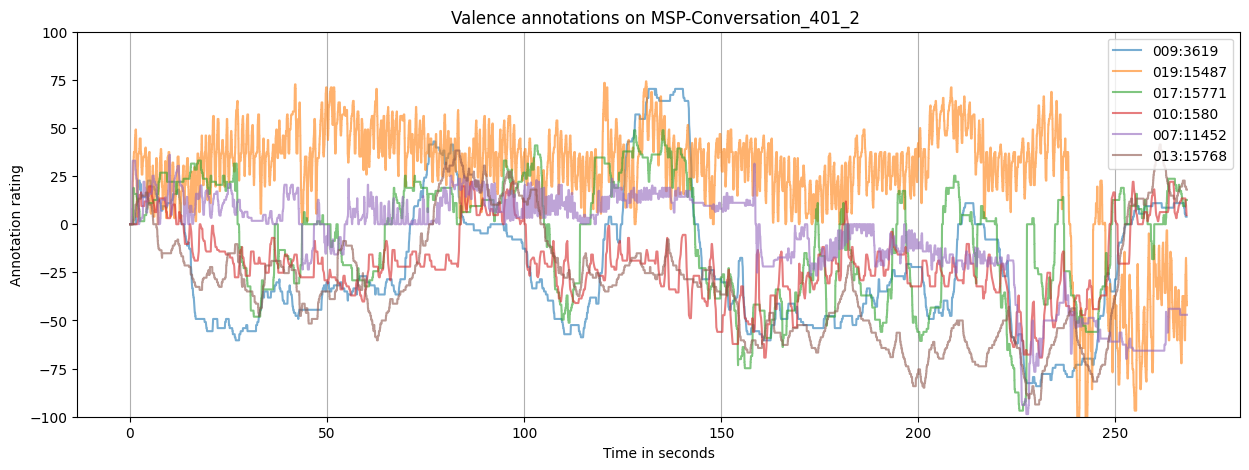

In [13]:
def plot_for_one_conversation_part(emot: str, dfa_filtered: pd.DataFrame, pc_num: int, part_num: int, zoom = None):
    plt.figure(figsize=(15,5))
    plt.title(f'{emot} annotations on MSP-Conversation_{pc_num}_{part_num} ')
    plt.ylim([-100, 100])
    if zoom is not None:
        plt.xlim(zoom)
    ax = plt.gca()
    ax.xaxis.grid(True)
    for dff in dfa_filtered:
        plt.plot(dff['Time'], dff['Annotation'], alpha=.6, label=dff['Annotator'].iloc[0])
    
    plt.ylabel('Annotation rating')
    plt.xlabel('Time in seconds')
    plt.legend()
    plt.show()


plot_for_one_conversation_part(EMO_Valence, dfannotation_vale_filtered, PC_Num, Part_Num, zoom=None) # zoom = [150, 200]


***

### *** end

In [115]:
# el objetico es que Time este en el orden ascendente para graficar las anotaciones del audio completo.
# (despues de 2 horas me di cuenta que) esta tarea no tiene sentido hasta que se haga un merge con 
# la media o alguna estrategia para sacar una solo anotacion de todos los anotadores.

PC_Num = 690
dfsimpleone = dfannotation[(dfannotation.PC_Num == PC_Num)] # From PC_Num, get all part to become a vstack - each part of PC_Num.

oneanns = []
for name, annotator, lines in zip(dfsimpleone['Name'], dfsimpleone['Annotator'], dfsimpleone['Lines']):
    tdf = pd.read_csv(f"{root_path}/Annotations/{EMO}/{name}", skiprows=9, header=None, names=['Time', 'Annotation'])
    tdf['Annotator'] = f"{annotator}:{lines}"
    # if len(oneanns) == 1:
    #     print(oneanns[0].iloc[-1].values[0])
    if len(oneanns) > 0:
        idx = len(oneanns)-1
        print(name, oneanns[idx].iloc[-1].values[0])
    oneanns.append(tdf)

tmp = pd.concat(oneanns)
m = 3030
tmp.iloc[m:m+50]


MSP-Conversation_0690_1_015.csv 328.0526
MSP-Conversation_0690_1_017.csv 328.0337
MSP-Conversation_0690_1_007.csv 328.1235
MSP-Conversation_0690_1_013.csv 328.1111
MSP-Conversation_0690_1_010.csv 328.1248
MSP-Conversation_0690_2_020.csv 328.1106
MSP-Conversation_0690_2_019.csv 319.271
MSP-Conversation_0690_2_017.csv 319.286
MSP-Conversation_0690_2_010.csv 319.3717
MSP-Conversation_0690_2_007.csv 319.2743
MSP-Conversation_0690_2_013.csv 319.3971
MSP-Conversation_0690_3_018.csv 319.3783
MSP-Conversation_0690_3_013.csv 270.5046
MSP-Conversation_0690_3_007.csv 270.9572
MSP-Conversation_0690_3_010.csv 271.0579
MSP-Conversation_0690_3_014.csv 270.9125
MSP-Conversation_0690_3_017.csv 270.9884


,Time,Annotation,Annotator
3030,327.26090,57.03,019:3038
3031,327.34200,50.78,019:3038
3032,327.44930,39.84,019:3038
3033,327.64400,25.78,019:3038
3034,327.75440,10.16,019:3038
3035,327.86220,10.16,019:3038
3036,327.94600,13.28,019:3038
3037,328.05260,19.53,019:3038
0,0.04000,0.00,015:4543
1,0.10788,0.00,015:4543
